# Multi-units order analysis for Fall 2021
Comments from Linda: I'm most interested in finding the multi unit orders from last Fall so we set ourselves up for success this coming season. 
I can't wait until you stitch together Q3,Oct,Nov,Dec files..

Original Location and csv files: S:\Olivia\Txn Data Extracts from Akshay  
1. Q3_2021_NEW_LOGIC_USING_UNITS_REFRESHED_MDR_SORTED.csv
2. OCTOBER_2021_NEW_LOGIC_USING_UNITS_REFRESHED_MDR_SORTED.csv
3. NOVEMBER_2021_NEW_LOGIC_USING_UNITS_REFRESHED_MDR_SORTED.csv
4. DECEMBER_2021_NEW_LOGIC_USING_UNITS_REFRESHED_MDR_SORTED.csv

To my directory: K:\Logistics\Co-op\Yongpeng\2021 Transaction Data from Olivia Q3 and Fall

## Ecomm – Make better decision
1. Top styles in each province so we can increase safety stock
2. Association (Based on the order # and not by split shipment, can you tell me what products are being ordered together so that we can co-locate the product in the same store so that all future orders can be shipped from a single location)
3. Prediction of selling curve

>comments from Linda:

>Here’s a list of questions I’d like you to solve: 
>1.	 What are the top styles in each province so we can increase safety stock…might be top items that cover 50% of the ecomm sales or a list of the top x# of styles.
>2.	Based on the order # and not by split shipment, can you tell me what products are being ordered together so that we can co-locate the product in the same store so that all future orders can be shipped from a single location.
>3.	Can you do a similar exercise that Olivia did for Spring and provide a list of styles that were ordered 3 or more units in the same order.  I’m looking to increase depth in the styles and answer if there are small businesses ordering multiple items.
>4.	If we get to this one, I might give you a fringe size sku list for Menswear to see if you can pull some insights.

>Comments from Linda for question 1: You would need to tally up total quantity sales by province, rank the styles and look for a good cutoff point.
75% cut off might be too much...it might equal a crazy 5000 styles...I'm just making this up...I have no idea.
See what the results are first and I can help determine cut off with you. You'll probably end up choosing a % cut off or # of styles cutoff.

>My comment:
I will move ahead with this approach and generate a distribution for all the styles in each province, 
and then extract those that have 70% (this can be changed) and to see if it is feasible or not



In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import defaultdict
from itertools import combinations
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

### Question 1: Find the top styles in each province so we can increase **safety stock**.   
You want find a threshold for each province so that a minimum list of styles can represent the majority of the items sold.

#### Some Clarification from Olivia (August 9 2022 using VM)
Good morning Olivia, thanks for the advice to only look at the Ecomm data. And after I merging dataset together, I noticed another 2 questions as attached. The 1st one is some negative number in the ITEM_QTY column. Why is that? Do I need to take them away? The 2nd question is the Store State/Prov and FULFIL_STORE_PROVINCE not the same. Yesterday, you mentioned that if FULFIL_STORE_PROVINCE is missing, I can use STORE_NUM to find out which province it belongs to. However, I think they are 2 different things, are they not?
![Question](./Image/Question.png)

Comments from Olivia:


So, negative quantities are returns txn . 344 is an online store (all web/tablet orders were 344). Fulfilled Store Prov for those returns txn would not be relevant anymore. If you want to know what the Initial fulfilling store number is, there's an attribute called "ORIG_FULFILL_STORE" or something like that in the dataset.

Ok, that makes sense. So what is difference between Store State/Prov and FULFIL_STORE_PROVINCE, besides what you mentioned 344 online store. My thought is: Store State/Prov is where this transaction is triggered, and FULFIL_STORE_PROVINCE is where this particular transaction is fulfiled?

If it's a sales txn, the two store prov should be the same. If it's a returns txn, the STORE_PROV would be where the person returning the product (i.e. mailing it back would goes to 344 and corp office prov is in Alberta. If they are returning it to store, then it should have the returning store# and the store Prov). I don't use Fulfilled_Store_Prov for returns. Again, check ORIG_FULFILL_STORE_PROV to be the safest or you can compare the two if there's any difference

Thank you Olivia. Ok, I want to give you a full picture of what I am doing. Attached is the whole features of this dataset, and red label is what I pulled out for now. And then the question I am looking after for is a top list of STYLEs that are most frequently purchased in different province.
![Full_Features](./Image/Full_Features.png)


In my opinion, you can exclude the Returns txn. I think the question you are trying to answer is based on sales only. To exclude returns, you can look into NORM SUB CHANNEL and filter on "GROSS WEB SALES". This way, you can just look at STORE_NUM without the ORIG_SHIP blah blah blah. Does that make sense?

Yes, you are right. I only need to look at sales only. So I put them in a summary: 1, because I only need to look at E-comm, I will filter on "`Norm Channel` == 'E-Comm'". 2, To exclude returns, I will look into NORM SUB CHANNEL and filter on "GROSS WEB SALES". 3, after these two filters, I will only pull the features for ['SALES_DATE', 'Transaction Number', 'STORE_NUM', 'Store State/Prov', 'Norm Channel', 'NORM SUB CHANNEL', 'SKU_NUM','ITEM_QTY', 'STYLE_NO']. I dont need ORIG_FULFILL_STORE_PROV because after these two filters, 'STORE_NUM' & 'Store State/Prov' will be the same as ORIG_FULFILL_STORE_PROV, right?

Yes, and to make your life even easier, filter on "Norm Sub Channel" is enough. The Gross Web Sales will take care of the "Norm Channel"

In [2]:
col_list_reduced = ['SALES_DATE', 'Transaction Number', 'ORDER_NUMBER', 'FULFILL_STORE', 'Selling Cycle', 'Norm Sub Channel',
                    'SKU_NUM', 'SKU_NAME', 'STYLE_NO', 'STYLE_NAME', 'COMMODITY_NO',
                    'COMMODITY_NAME', 'ITEM_QTY', 'SHIPPED_TO_POSTALCODE', 'SHIPPED_TO_CITY', 'SHIPPED_TO_PROVINCE']
dtypes = {"Transaction Number":"str", 'ORDER_NUMBER':'str', 'FULFILL_STORE':'str', 'Selling Cycle':'str', 'Norm Sub Channel':"str", 
          "SKU_NUM":"str", 'SKU_NAME':"str", "STYLE_NO":"str", 'STYLE_NAME':'str', 'COMMODITY_NO':'str',
          'COMMODITY_NAME':'str', "ITEM_QTY":"int",
         'SHIPPED_TO_POSTALCODE':"str", 'SHIPPED_TO_CITY':"str", 'SHIPPED_TO_PROVINCE':"str"}
#read in the csv
OCTOBER_2021_reduced_web_ecomm_pre = pd.read_csv(r"S:/Olivia/Txn Data Extracts from Akshay/OCTOBER_2021_NEW_LOGIC_USING_UNITS_REFRESHED_MDR_SORTED.csv",
                          usecols = col_list_reduced, engine = 'c',dtype=dtypes, parse_dates = ["SALES_DATE"], encoding='latin1', chunksize = 10000000)
OCTOBER_2021_reduced_web_ecomm_final = pd.concat([chunk.query("`Norm Sub Channel` == 'GROSS WEB SALES'") for chunk in OCTOBER_2021_reduced_web_ecomm_pre], ignore_index = True)

NOVEMBER_2021_reduced_web_ecomm_pre = pd.read_csv(r"S:/Olivia/Txn Data Extracts from Akshay/NOVEMBER_2021_NEW_LOGIC_USING_UNITS_REFRESHED_MDR_SORTED.csv",
                          usecols = col_list_reduced, engine = 'c',dtype=dtypes, parse_dates = ["SALES_DATE"],encoding='latin1',chunksize = 10000000)
NOVEMBER_2021_reduced_web_ecomm_final = pd.concat([chunk.query("`Norm Sub Channel` == 'GROSS WEB SALES'") for chunk in NOVEMBER_2021_reduced_web_ecomm_pre], ignore_index = True)

DECEMBER_2021_reduced_web_ecomm_pre = pd.read_csv(r"S:/Olivia/Txn Data Extracts from Akshay/DECEMBER_2021_NEW_LOGIC_USING_UNITS_REFRESHED_MDR_SORTED.csv",
                          usecols = col_list_reduced, engine = 'c',dtype=dtypes, parse_dates = ["SALES_DATE"],encoding='latin1',chunksize = 10000000)
DECEMBER_2021_reduced_web_ecomm_final = pd.concat([chunk.query("`Norm Sub Channel` == 'GROSS WEB SALES'") for chunk in DECEMBER_2021_reduced_web_ecomm_pre], ignore_index = True)

Q3_2021_reduced_web_ecomm_pre = pd.read_csv(r"S:/Olivia/Txn Data Extracts from Akshay/Q3_2021_NEW_LOGIC_USING_UNITS_REFRESHED_MDR_SORTED.csv",
                          usecols = col_list_reduced, engine = 'c',dtype=dtypes, parse_dates = ["SALES_DATE"],encoding='latin1',chunksize = 10000000)
Q3_2021_reduced_web_ecomm_final = pd.concat([chunk.query("`Norm Sub Channel` == 'GROSS WEB SALES'") for chunk in Q3_2021_reduced_web_ecomm_pre], ignore_index = True)

Fall_2021_reduced_web_ecomm_final = pd.concat([Q3_2021_reduced_web_ecomm_final, OCTOBER_2021_reduced_web_ecomm_final, NOVEMBER_2021_reduced_web_ecomm_final, DECEMBER_2021_reduced_web_ecomm_final])
Fall_2021_reduced_web_ecomm_final.to_csv(r"K:\Logistics\Co-op\Yongpeng\2021 Transaction Data from Olivia Q3 and Fall\Yongpeng Fu August 9 2022\Fall_2021_reduced_web_ecomm_final.csv", index = False)
#Since I have saved the results, I will just load them directly.
Fall_2021_reduced_web_ecomm_final = pd.read_csv(r"K:\Logistics\Co-op\Yongpeng\2021 Transaction Data from Olivia Q3 and Fall\Yongpeng Fu August 9 2022\Fall_2021_reduced_web_ecomm_final.csv",
                                               dtype=dtypes, parse_dates = ["SALES_DATE"])

#So, negative quantities are returns txn . 344 is an online store (all web/tablet orders were 344). 
#Fulfilled Store Prov for those returns txn would not be relevant anymore. I will filter out any rows that have < 0 quantity
Fall_2021_reduced_ecomm_final_Item_pos = Fall_2021_reduced_web_ecomm_final.query("ITEM_QTY > 0")

#before filter out rows that SHIPPED_TO_POSTALCODE is NA
print(Fall_2021_reduced_ecomm_final_Item_pos.shape)
print(Fall_2021_reduced_ecomm_final_Item_pos.dropna(subset = ['SHIPPED_TO_POSTALCODE']).shape)
Fall_2021_reduced_ecomm_final_Item_pos_code = Fall_2021_reduced_ecomm_final_Item_pos.dropna(subset = ['SHIPPED_TO_POSTALCODE'])
display(Fall_2021_reduced_web_ecomm_final.head(2))

(2640110, 16)
(2635868, 16)


,SALES_DATE,Transaction Number,ORDER_NUMBER,SKU_NUM,ITEM_QTY,Norm Sub Channel,COMMODITY_NO,COMMODITY_NAME,STYLE_NO,STYLE_NAME,SKU_NAME,Selling Cycle,FULFILL_STORE,SHIPPED_TO_POSTALCODE,SHIPPED_TO_CITY,SHIPPED_TO_PROVINCE
0,2021-07-06,30841,1000005750,410017480915,1,GROSS WEB SALES,5D-QB,LADIES CASUAL,33645-BLK,SKECHERS BOBS PLUSH PEACE/LOVE SLIP ON SHOES - B,SKECHERS BOBS PLUSH PEACE/LOV BLACK 8 REG,All Season,526,J7H 0A2,Boisbriand,QC
1,2021-07-04,11849,1000005920,410015579703,1,GROSS WEB SALES,4A-MC,DENVER HAYES,4AMCDHAS19123,DH STRAIGHT FIT VALUE STRETCH LIGHT WASH,DH STRAIGHT FIT VALUE STRETCH LTWASH W36 L28,All Season,156,K7L 1H3,Kingston,ON


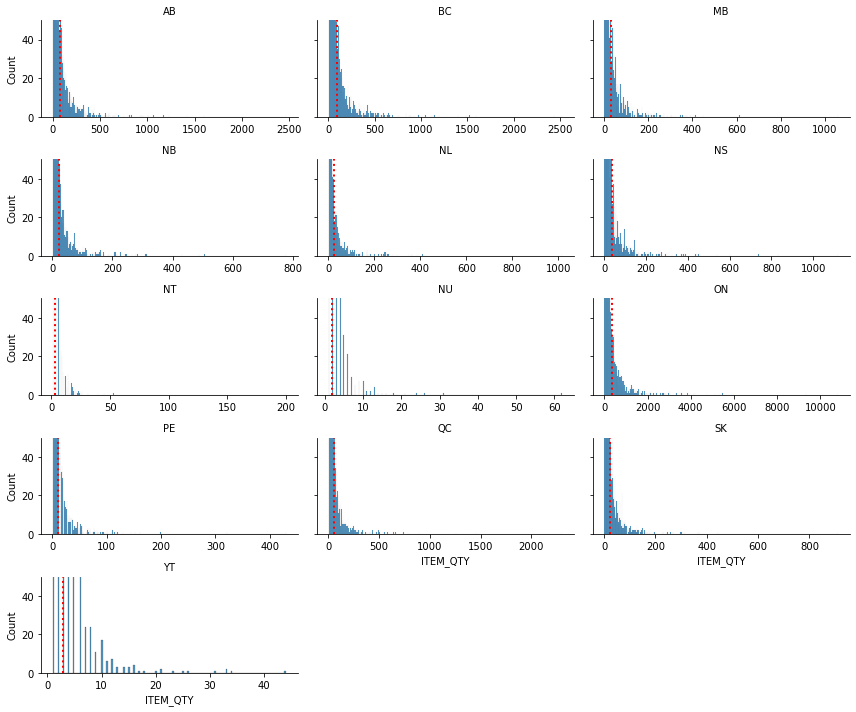

In [4]:
#groupby the 'SHIPPED_TO_Region', 'STYLE_NO' and get a sum for ['ITEM_QTY'].
groupby_region_style_sum_item = Fall_2021_reduced_ecomm_final_Item_pos_code.groupby(['SHIPPED_TO_PROVINCE', 'STYLE_NO', 'STYLE_NAME', 'Selling Cycle'])['ITEM_QTY'].sum().reset_index()
#the new dataframe, we want to get the top 10 rows that have the highest ITEMS sold for this style in this particular region
# groupby_region_style_sum_item_top10 = groupby_region_style_sum_item.sort_values(by = ['ITEM_QTY'],ascending=False).groupby(['SHIPPED_TO_PROVINCE', 'STYLE_NO']).head(10)
groupby_region_style_sum_item.set_index(['STYLE_NO',  'STYLE_NAME', 'Selling Cycle']).groupby('SHIPPED_TO_PROVINCE')['ITEM_QTY'].nlargest(20).reset_index().head(2)
# groupby_region_style_sum_item.set_index(['STYLE_NO']).groupby('SHIPPED_TO_Region')['ITEM_QTY'].nlargest(20).reset_index().to_csv(r"C:\Users\yongpeng.fu\OneDrive - Canadian Tire\Desktop\groupby_region_sum_item_top20.csv", index = False)

# # figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

#define a function to find position of a sorted array (from biggest to smallest) based on percentage
#so that the values added up to the left of this position 
def find_cut_point(group, percentage = 100):
    item_sorr_arr = group.sort_values(by = 'ITEM_QTY',ascending=False)['ITEM_QTY']
    item_sorr_arr_sum = item_sorr_arr.sum()
    #the tally of item_quantity up to this point
    sum_item = 0
    for i, v in item_sorr_arr.items():
        sum_item += v
        if sum_item>= item_sorr_arr_sum*(percentage/100):
            return i

#Generate a list of 50 percentile for ITEM_QTY in different provinces
percentile_list = []
for _, group in groupby_region_style_sum_item.groupby(['SHIPPED_TO_PROVINCE']):
    percentile_list.append(find_cut_point(group, 60))

#the following is to show the distribution groupby_region_style_sum_item in different province
#https://stackoverflow.com/questions/66154773/how-to-add-individual-vlines-to-every-subplot-of-seaborn-facetgrid
grid = sns.FacetGrid(groupby_region_style_sum_item, col = "SHIPPED_TO_PROVINCE", 
                     height = 2, col_wrap = 3,sharey = True, sharex = False,
                    ylim = (0,50),aspect = 2)
grid.map(sns.histplot, "ITEM_QTY")
grid.set_titles("{col_name}")
#add the vertical line in each subplots
for ax, pos in zip(grid.axes.flat, groupby_region_style_sum_item.loc[percentile_list].ITEM_QTY.to_numpy()):
    ax.axvline(x=pos, color='r', linestyle=':', linewidth = 2)
plt.show()

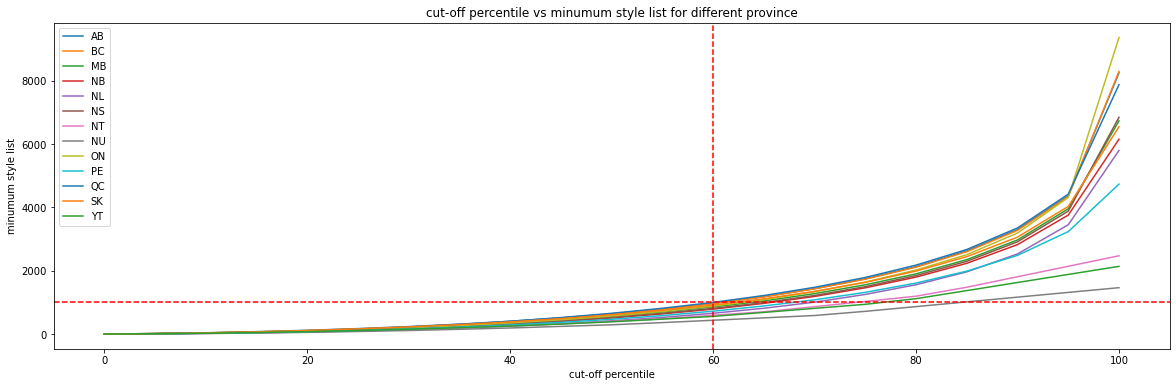

In [5]:
#define a function to find position of a sorted array (from biggest to smallest) based on percentage
#so that the values added up to the left of this position 
def find_cut_point(group, percentage = 100):
    item_sorr_arr = group.sort_values(by = 'ITEM_QTY',ascending=False)['ITEM_QTY']
    item_sorr_arr_sum = item_sorr_arr.sum()
    #the tally of item_quantity up to this point
    sum_item = 0
    for i, v in item_sorr_arr.items():
        sum_item += v
        if sum_item>= item_sorr_arr_sum*(percentage/100):
            return i

#Generate a list of 50 percentile for ITEM_QTY in different provinces
def style_percentile(percentage = 100):
    style_list_prov = defaultdict(list)
    info_return_percentage = []
    for name, group in groupby_region_style_sum_item.groupby(['SHIPPED_TO_PROVINCE']):
        index_percentile = find_cut_point(group, percentage)
        #find the list of styles (or quantity) up to this position for a sorted array (from biggest to smallest) for each group
        STYLE_NO_sort_arr = group.sort_values(by = 'ITEM_QTY',ascending=False)
        #the top style list that makes up the *percentage of the whole list based on the summary of their ITEM_QTY
        style_percentile_list = STYLE_NO_sort_arr.loc[:index_percentile]
        info_return_percentage.append(style_percentile_list)
        style_list_prov["Province"].append(name)
        style_list_prov["Percentile"].append(percentage)
        style_list_prov["total_style"].append(len(style_percentile_list))
#         style_list_prov["total_style_list"].append(style_percentile_list)
    return pd.DataFrame(style_list_prov), info_return_percentage
# step through percentile from 0 to 100% with 5 % at a time
dataframe_percentile = []
for perc in range(0, 105, 5):
    dataframe_percentile.append(style_percentile(perc)[0])
groupby_region_style_sum_item_varying_percentile = pd.concat(dataframe_percentile)
# groupby_region_style_sum_item_varying_percentile.to_csv(r"C:\Users\yongpeng.fu\OneDrive - Canadian Tire\Desktop\groupby_region_style_sum_item_varying_percentile.csv", index = False)
groupby_region_style_sum_item_varying_percentile.set_index('Percentile').groupby('Province')['total_style'].plot(legend = True,figsize = (20,6), 
                                                                                                                 title = "cut-off percentile vs minumum style list for different province",
                                                                                                                xlabel = 'cut-off percentile',
                                                                                                                ylabel = 'minumum style list')
plt.axvline(60,color='red', linestyle='--')
plt.axhline(1000,color='red', linestyle='--')
plt.show()

#based on the percentile you chose, write out the excel sheet for those STYLE
pd.concat(style_percentile(60)[1]).to_csv(r"K:\Logistics\Co-op\Yongpeng\2021 Transaction Data from Olivia Q3 and Fall\Yongpeng Fu August 9 2022\groupby_region_style_sum_item_top60_percent_style_list.csv")

#find the common STYLEs in each different province. Because we know NT, NU and YT only have small purchased quantity,
#I will exclude them from this analysis
groupby_region_style_sum_item_top60_percent_style_list = pd.read_csv(r"K:\Logistics\Co-op\Yongpeng\2021 Transaction Data from Olivia Q3 and Fall\Yongpeng Fu August 9 2022\groupby_region_style_sum_item_top60_percent_style_list.csv").iloc[:, 1:]
groupby_region_style_sum_item_top60_percent_style_list = groupby_region_style_sum_item_top60_percent_style_list[~groupby_region_style_sum_item_top60_percent_style_list.SHIPPED_TO_PROVINCE.isin([ "NT","NU","YT"])]
# province_combinations = combinations(groupby_region_style_sum_item_top60_percent_style_list.SHIPPED_TO_PROVINCE.unique(), 2)
# for i in list(province_combinations):
#     print(i)
common_style = groupby_region_style_sum_item_top60_percent_style_list.query("SHIPPED_TO_PROVINCE == 'AB'").STYLE_NO.values
for _, value in groupby_region_style_sum_item_top60_percent_style_list.groupby('SHIPPED_TO_PROVINCE')['STYLE_NO']:
    common_style = np.intersect1d(common_style, value.values)
pd.DataFrame(common_style).to_csv(r"C:\Users\yongpeng.fu\OneDrive - Canadian Tire\Desktop\common_style.csv")

#### Summary for What are the top styles in each province so we can increase safety stock…might be top items that cover 60% of the ecomm sales or a list of the top x# of styles

1. From the Distribution part, we can see there is skwed distribution for how many units were sold on the style level, which is in our favour because we want to use as few styles as possible to represent as much the purchased quantity as possible. The red vertical line indicates is to split the distribution into 2 parts, to the right part is what are interested most because they are purchased more often than the left part. The red line itself is a percentile that the right part is representing.
2. From the "Find the sweat spot where the minimum number of styles represent the most of the Items purchased", we can see that the total number of styles needed to fultil the cut-off percentile is growing slow until 80-100%, which is good for us because then we can use minumum styles to cover the majority of the purchased orders. I find 60% is relatively good because all provinces just need less 1000 styles to meet this requirement.

### Question 2:  Association

1. Based on the order # and not by split shipment, can you tell me what products are being ordered together so that we can co-locate the product in the same store so that all future orders can be shipped from a single location.
    *You may want to only look at the order that has more than 1 items because you want to find the association between items
2. Knowledge Check.  
    *https://medium.com/@24littledino/association-mining-support-association-rules-and-confidence-60132a37e355  
    *https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/  
    *https://towardsdev.com/support-association-rules-and-confidence-in-python-bd71cd08a920  
    *https://www.geeksforgeeks.org/implementing-apriori-algorithm-in-python/  
    *http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/  
    *https://www.youtube.com/watch?v=lN5WRWoY14Q&t=120s  
    *https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6  
    
    > **Support**: Support (relative support) is the proportion of transactions containing a certain item set. An item set can contain more than one item. Support(B) = (Transactions containing (B))/(Total Transactions)  ![Apriori](./Image/apriori.png)
    
    >**Association rules**:: An association rule represents the pattern/co-occurrence of two item sets by using an if-then condition. For example, a rule (Apple) → (Banana) means “IF Apple is in a transaction, THEN Banana is also in that transaction”.  
    
    >**Confidence**: Support measures the frequency of item sets co-occurring in a rule, and Confidence is a reliability measure of a rule. Confidence refers to the likelihood that an item B is also bought if item A is bought. It can be calculated by finding the number of transactions where A and B are bought together, divided by total number of transactions where A is bought. Mathematically, it can be represented as: Confidence(A→B) = (Transactions containing both (A and B))/(Transactions containing A)
    
    >**Frequent Item Set**: An itemset whose support is greater than or equal to a minSup threshold. Frequent itemsets or also known as frequent pattern simply means all the itemsets that the support satisfies the minimum support threshold. https://www.youtube.com/watch?v=lN5WRWoY14Q&t=120s
    
    > **Lift**: Lift(A -> B) refers to the increase in the ratio of sale of B when A is sold. Lift(A –> B) can be calculated by dividing Confidence(A -> B) divided by Support(B). Mathematically it can be represented as: Lift(A→B) = (Confidence (A→B))/(Support (B)). For example: Lift(Burger→Ketchup) = (Confidence (Burger→Ketchup))/(Support (Ketchup))Lift(Burger→Ketchup) = 33.3/10 = 3.33.  
    Lift basically tells us that the likelihood of buying a Burger and Ketchup together is 3.33 times more than the likelihood of just buying the ketchup. A Lift of 1 means there is no association between products A and B. Lift of greater than 1 means products A and B are more likely to be bought together. Finally, Lift of less than 1 refers to the case where two products are unlikely to be bought together.
    
    > **Strong association rules**: The association mining is a user-dependent subject, so whether a rule is strong is also defined by the users. To be more concrete, we can define a minimum support and minimum confidence of the rules. If the support of a rule ≥ minimum support AND the confidence ≥ minimum confidence, then the rule is considered strong.
        >> For instance, if we set the minimum support as 1/2 and the minimum confidence as 1/2, then the rule (Apple) → (Banana) is strong, while the rule (Banana) → (Apple) is NOT strong (its confidence is less than 1/2).
        
    > Steps:
        1. Set a minimum value for support and confidence. This means that we are only interested in finding rules for the items that have certain default existence (e.g. support) and have a minimum value for co-occurrence with other items (e.g. confidence).
        2. Extract all the subsets having higher value of support than minimum threshold.
        3. Select all the rules from the subsets with confidence value higher than minimum threshold.
        4. Order the rules by descending order of Lift.

In [ ]:
#This section is done in the VM and the purpose here is to reduce the size of original excel by only retaining
#the ORDER_NUMBER that has more than 2 SKU sold inside

#read in data
#I am just using the style list that makes up 60% of total sales for each province
# col_list_reduced = ['STYLE_NO','SHIPPED_TO_PROVINCE']
# dtypes = {"STYLE_NO":"str", 'SHIPPED_TO_PROVINCE':"str"}
# groupby_region_style_sum_item_top60_percent_style_list_reduced = pd.read_csv(r"S:\Olivia\Txn Data Extracts from Akshay\Yongpeng Fu August 9 2022\groupby_region_style_sum_item_top60_percent_style_list.csv",
#                                                                     usecols = col_list_reduced,dtype=dtypes)
col_list_reduced = ['ORDER_NUMBER','SKU_NUM','SKU_NAME', 'STYLE_NO', 'STYLE_NAME', 'COMMODITY_NO',
                    'COMMODITY_NAME', 'SHIPPED_TO_PROVINCE', 'ITEM_QTY']
dtypes = {'ORDER_NUMBER':'str', "SKU_NUM":"str", "SKU_NAME":"str", "STYLE_NO":"str", "STYLE_NAME":"str", 'COMMODITY_NO':'str',
                    'COMMODITY_NAME':'str', "ITEM_QTY":"int",'SHIPPED_TO_PROVINCE':"str"}
Fall_2021_reduced_web_ecomm_final_reduced = pd.read_csv(r"S:\Olivia\Txn Data Extracts from Akshay\Yongpeng Fu August 9 2022\Fall_2021_reduced_web_ecomm_final.csv",
                                               usecols = col_list_reduced,dtype=dtypes)
# #create a new dataframe and only retain the STYLE_NO list from groupby_region_style_sum_item_top60_percent_style_list_reduced for each province
# new_list_temp = []
# for name, value in Fall_2021_reduced_web_ecomm_final_reduced.groupby('SHIPPED_TO_PROVINCE'):
#     new_list_temp.append(value[value['STYLE_NO'].isin(groupby_region_style_sum_item_top60_percent_style_list_reduced.query(f"SHIPPED_TO_PROVINCE == '{name}'")["STYLE_NO"])])
# Fall_2021_reduced_web_ecomm_final_reduced_top60 = pd.concat(new_list_temp).to_csv(r"S:\Olivia\Txn Data Extracts from Akshay\Yongpeng Fu August 9 2022\Fall_2021_reduced_web_ecomm_final_reduced_top60.csv")


#Additional step: groupby the ORDER_NUMBER and filter out any ORDER_NUMBER that has less than 2 different SKUs
ORDER_NUMBER_morethan_2_index = Fall_2021_reduced_web_ecomm_final_reduced.ORDER_NUMBER.value_counts()[Fall_2021_reduced_web_ecomm_final_reduced.ORDER_NUMBER.value_counts()>1].index
Fall_2021_reduced_web_ecomm_final_duplicated_index = Fall_2021_reduced_web_ecomm_final_reduced[Fall_2021_reduced_web_ecomm_final_reduced.ORDER_NUMBER.isin(ORDER_NUMBER_morethan_2_index)]
Fall_2021_reduced_web_ecomm_final_duplicated_index.to_csv(r"K:\Logistics\Co-op\Yongpeng\2021 Transaction Data from Olivia Q3 and Fall\Yongpeng Fu August 9 2022\Fall_2021_reduced_web_ecomm_final_duplicated_index.csv")

In [6]:
#This section is done in the local computer
import pandas as pd

#read in data
# dtypes = {'ORDER_NUMBER':'str', "SKU_NUM":"str", "SKU_NAME":"str", "STYLE_NO":"str", "STYLE_NAME":"str", 'COMMODITY_NO':'str',
#                     'COMMODITY_NAME':'str', "ITEM_QTY":"int",'SHIPPED_TO_PROVINCE':"str"}
dtypes = {'ORDER_NUMBER':'str', "SKU_NUM":"str", "STYLE_NO":"str", 'COMMODITY_NO':'str',
                    'COMMODITY_NAME':'str', "ITEM_QTY":"int",'SHIPPED_TO_PROVINCE':"str"}
Fall_2021_reduced_web_ecomm_final_duplicated_index = pd.read_csv(r"K:\Logistics\Co-op\Yongpeng\2021 Transaction Data from Olivia Q3 and Fall\Yongpeng Fu August 9 2022\Fall_2021_reduced_web_ecomm_final_duplicated_index.csv",
                                                                dtype=dtypes).iloc[:, 1:]
#remove records that any of the following columns have NaN inthere
Fall_2021_reduced_web_ecomm_final_duplicated_index.dropna(how = 'any', subset = ['SKU_NUM', 'STYLE_NO', 'COMMODITY_NO', 'SHIPPED_TO_PROVINCE'], inplace = True)

In [7]:
#Find which level of item is best suited to do apriori algorithm
def find_unique(level):
    order_list = []
    for _, group in Fall_2021_reduced_web_ecomm_final_duplicated_index.groupby('ORDER_NUMBER'):
        style_set = set(group[level].astype(str).tolist()) #only get the unique ID
        if len(style_set) > 1: #only 
            order_list.append(style_set)
    return order_list
print('------------------------------------SKU Level ----------------------------------------')
print(f'Unique SKUs: {len(Fall_2021_reduced_web_ecomm_final_duplicated_index.SKU_NUM.unique())}. \
Total Order Number that has at least 2 different SKUs: {len(find_unique("SKU_NUM"))}. \
Required Order Number for 0.1%: {round(len(find_unique("SKU_NUM")) * 0.001)}')
print('------------------------------------STYLE Level ----------------------------------------')
print(f'Unique STYLEs: {len(Fall_2021_reduced_web_ecomm_final_duplicated_index.STYLE_NO.unique())}. \
Total Order Number that has at least 2 different STYLEs: {len(find_unique("STYLE_NO"))}. \
Required Order Number for 0.1%: {round(len(find_unique("STYLE_NO")) * 0.001)}')
print('------------------------------------Commodity Level ----------------------------------------')
print(f'Unique COMMODITYs: {len(Fall_2021_reduced_web_ecomm_final_duplicated_index.COMMODITY_NO.unique())}. \
Total Order Number that has at least 2 different COMMODITYs: {len(find_unique("COMMODITY_NO"))}. \
Required Order Number for 0.1%: {round(len(find_unique("COMMODITY_NO")) * 0.001)}')

------------------------------------SKU Level ----------------------------------------
Unique SKUs: 62273. Total Order Number that has at least 2 different SKUs: 554614. Required Order Number for 0.1%: 555
------------------------------------STYLE Level ----------------------------------------
Unique STYLEs: 9363. Total Order Number that has at least 2 different STYLEs: 492640. Required Order Number for 0.1%: 493
------------------------------------Commodity Level ----------------------------------------
Unique COMMODITYs: 173. Total Order Number that has at least 2 different COMMODITYs: 395995. Required Order Number for 0.1%: 396


In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import defaultdict
from itertools import combinations
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder


#Step 1: do some data cleaning
# Stripping extra spaces in the SKU_NUM
# Fall_2021_reduced_web_ecomm_final['STYLE_NO'] = Fall_2021_reduced_web_ecomm_final['STYLE_NO'].str.strip()
# Dropping the rows without any ORDER_NUMBER
# Fall_2021_reduced_web_ecomm_final_reduced_top60.dropna(axis = 0, subset =['ORDER_NUMBER'], inplace = True)
#Step 2: groupby the ORDER_NUMBER and filter out any ORDER_NUMBER that has less than 2 different SKUs
# ORDER_NUMBER_morethan_2_index = Fall_2021_reduced_web_ecomm_final.ORDER_NUMBER.value_counts()[Fall_2021_reduced_web_ecomm_final.ORDER_NUMBER.value_counts()>1].index
# Fall_2021_reduced_web_ecomm_final = Fall_2021_reduced_web_ecomm_final[Fall_2021_reduced_web_ecomm_final.ORDER_NUMBER.isin(ORDER_NUMBER_morethan_2_index)]

# Defining the hot encoding function to make the data suitable 
# for the concerned libraries
# def hot_encode(x):
#     if(x<= 0):
#         return False
#     if(x>= 1):
#         return True
# #encoding the datasets
# Fall_2021_reduced_web_ecomm_final_duplicated_index_encode =(Fall_2021_reduced_web_ecomm_final_duplicated_index
#                                        .groupby(['ORDER_NUMBER', 'SKU_NUM'])['ITEM_QTY'].sum().unstack()
#                                        .reset_index().fillna(0).set_index('ORDER_NUMBER')).applymap(hot_encode)

#because 
#SKU in the same order
order_list = []
for _, group in Fall_2021_reduced_web_ecomm_final_duplicated_index.query("SHIPPED_TO_PROVINCE == 'BC'").groupby('ORDER_NUMBER'):
    style_set = set(group['STYLE_NAME'].astype(str).tolist()) #only get the unique ID
    if len(style_set) > 1: #only retain the order that has more than 1 items sold there
        order_list.append(style_set)
#We can transform it into the right format via the TransactionEncoder as follows:
te = TransactionEncoder()
te_ary = te.fit(order_list).transform(order_list, sparse=True)
order_list_df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

'''
Now let’s try finding frequent item sets given a minimum support of 0.6 using apriori an algorithm. 
Namely, these item sets occur in at least 60% of transactions.
To illustrate, frequent item sets are item sets having support ≥ minimum support.
'''
#building the model
frequent_items = apriori(order_list_df, min_support=0.005, use_colnames=True,verbose=1)
frequent_items.to_csv(r"C:\Users\yongpeng.fu\OneDrive - Canadian Tire\Desktop\frequent_items_SKUsupport001.csv")
#collecting the inferred rules in a dataframe
# rules = association_rules(frequent_items, metric ="confidence", min_threshold = 0.1)
# rules = rules.sort_values(by='confidence', ascending =False)
rules = association_rules(frequent_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules.to_csv(r"C:\Users\yongpeng.fu\OneDrive - Canadian Tire\Desktop\strong_rules_SKUsupport001_lift1.csv")
rules